# Run the methane adaptive removal algorithm

- fair v2.1.3
- calibration v1.4.0

We could use calibration v1.4.1 but would require re-harmonizing scenarios including the C2 scenario to 2022/2023, so we don't do this.

Note in both cases we save out *raw temperatures*. In the calibration the comparison against 1.5C is always 2003-2022 defined as 1.03C.

In [1]:
import copy
import os

import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import pooch
from tqdm.auto import tqdm
import xarray as xr

from fair import FAIR
from fair.io import read_properties
from fair.interface import initialise, fill

In [2]:
n_ens = 841

In [3]:
pd.options.display.max_columns = 50
df_configs = pd.read_csv('../data/fair2.1-parameters/calibration-1.4.0/calibrated_constrained_parameters.csv', index_col=0)
valid_all = list(df_configs.index)[:n_ens]
df_configs

,clim_gamma,clim_c1,clim_c2,clim_c3,clim_kappa1,clim_kappa2,clim_kappa3,clim_epsilon,clim_sigma_eta,clim_sigma_xi,clim_F_4xCO2,cc_r0,cc_rU,cc_rT,cc_rA,ari_BC,ari_CH4,ari_N2O,ari_NH3,ari_NOx,ari_OC,ari_Sulfur,ari_VOC,ari_Equivalent effective stratospheric chlorine,aci_shape_so2,aci_shape_bc,aci_shape_oc,aci_beta,o3_CH4,o3_N2O,o3_Equivalent effective stratospheric chlorine,o3_CO,o3_VOC,o3_NOx,fscale_CH4,fscale_N2O,fscale_minorGHG,fscale_Stratospheric water vapour,fscale_Land use,fscale_Volcanic,fscale_solar_amplitude,fscale_solar_trend,fscale_Light absorbing particles on snow and ice,fscale_CO2,cc_co2_concentration_1750,seed
1439,4.044797,3.732965,32.263983,107.126387,1.013820,2.076222,0.840497,1.063253,0.793965,0.472531,7.365090,31.713504,0.004164,4.229310,0.000329,0.001381,-0.000002,-0.000016,-0.000057,-0.000111,-0.007696,-0.003801,-0.000009,-0.000004,9.434053e-03,7.109620e-14,6.062952e-02,-1.417302,0.000196,0.001512,-0.000023,0.000016,0.000213,0.000837,0.985031,1.158661,1.149252,1.603529,0.691392,0.815222,1.425049,-0.043510,0.955256,0.958703,279.247866,1929924
2367,4.853979,3.810277,20.467382,102.443422,0.834987,2.868009,0.668570,1.037842,1.273334,0.597019,7.340256,33.228398,0.003673,0.794713,0.004021,0.036455,-0.000003,-0.000063,-0.000969,-0.000089,-0.003923,-0.003596,-0.000012,-0.000010,9.490808e-07,2.110837e-08,4.495463e-06,-6602.362403,0.000290,0.001384,-0.000050,0.000080,-0.000120,0.000397,1.072174,0.919939,1.122265,0.129380,0.892936,0.955571,1.365904,-0.049228,1.230376,0.956818,276.268424,2300196
2658,7.955813,2.372091,24.244896,85.804074,1.684862,2.102202,0.649919,0.968436,1.417742,0.228200,6.541059,33.703571,0.005577,0.300412,0.000923,0.020415,-0.000002,-0.000013,-0.000024,-0.000090,-0.005956,-0.001160,-0.000009,-0.000010,7.715318e-03,2.205669e+04,3.385174e-11,-0.742211,0.000290,0.001390,-0.000034,0.000131,-0.000164,0.001734,0.777347,0.789664,0.899906,0.383282,0.914854,0.744196,0.458884,-0.002800,1.581370,0.903196,276.858025,2416305
2806,2.937705,6.138269,20.411226,117.261130,1.378548,2.083664,1.503581,1.329205,0.963360,0.568642,8.886224,29.840433,0.005936,3.306367,0.001324,0.040931,-0.000004,-0.000004,-0.001105,-0.000104,-0.006560,-0.001634,-0.000021,-0.000014,1.141537e-01,3.061416e-38,2.097737e-01,-0.655692,0.000212,0.001259,-0.000073,0.000075,-0.000208,0.001639,1.009300,0.915911,1.066496,0.344523,1.480948,1.062654,1.133202,0.007763,0.082247,1.063392,279.041303,2475357
5770,14.633055,4.565096,12.566855,89.539113,1.347967,3.503588,0.844045,1.686560,1.196240,0.430562,7.905946,37.083940,0.000733,1.311009,0.001705,0.023259,-0.000003,-0.000064,-0.000671,-0.000062,-0.006372,-0.002916,-0.000021,-0.000009,1.712264e-06,4.298920e-14,4.829064e-06,-2479.565225,0.000223,0.001243,-0.000127,0.000213,0.000021,0.000948,1.070312,0.799293,1.107884,2.160383,0.792396,0.928417,1.044089,0.018427,1.379437,0.998042,277.192553,3657993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592481,13.081141,3.092177,7.943416,63.972597,0.971946,5.506738,0.938731,1.651418,1.261861,0.595008,7.484995,29.157370,0.008161,0.289227,0.003596,0.040291,-0.000001,-0.000030,-0.001069,-0.000127,-0.000318,-0.003556,-0.000017,-0.000008,6.772212e-04,7.045381e-03,3.397262e-26,-9.511945,0.000216,0.000661,-0.000083,0.000113,0.000102,0.002282,1.073550,1.068153,1.043409,0.092013,1.331587,1.074477,1.372370,-0.018395,0.647033,0.967516,276.937273,636755682
1593875,4.380900,5.670989,26.814287,77.727483,0.914393,2.171273,1.304101,1.379901,1.050203,0.610411,6.039452,33.832620,0.002180,3.620377,0.001406,0.038097,-0.000001,-0.000020,-0.000143,-0.000100,-0.007210,-0.004018,-0.000008,-0.000004,8.042293e-07,3.159365e-04,8.153508e-06,-389.524117,0.000234,0.001327,-0.000036,0.000180,0.000049,0.000574,1.011755,0.944703,1.040278,0.573622,0.983854,1.042476,1.288003,0.004834,1.621672,0.868997,277.420698,637311888
1595217,6.505919,4.616381,13.129929,1

In [4]:
df_configs.columns

Index(['clim_gamma', 'clim_c1', 'clim_c2', 'clim_c3', 'clim_kappa1',
       'clim_kappa2', 'clim_kappa3', 'clim_epsilon', 'clim_sigma_eta',
       'clim_sigma_xi', 'clim_F_4xCO2', 'cc_r0', 'cc_rU', 'cc_rT', 'cc_rA',
       'ari_BC', 'ari_CH4', 'ari_N2O', 'ari_NH3', 'ari_NOx', 'ari_OC',
       'ari_Sulfur', 'ari_VOC',
       'ari_Equivalent effective stratospheric chlorine', 'aci_shape_so2',
       'aci_shape_bc', 'aci_shape_oc', 'aci_beta', 'o3_CH4', 'o3_N2O',
       'o3_Equivalent effective stratospheric chlorine', 'o3_CO', 'o3_VOC',
       'o3_NOx', 'fscale_CH4', 'fscale_N2O', 'fscale_minorGHG',
       'fscale_Stratospheric water vapour', 'fscale_Land use',
       'fscale_Volcanic', 'fscale_solar_amplitude', 'fscale_solar_trend',
       'fscale_Light absorbing particles on snow and ice', 'fscale_CO2',
       'cc_co2_concentration_1750', 'seed'],
      dtype='object')

In [5]:
df_solar = pd.read_csv(
    "../data/forcing/solar_erf_timebounds.csv", index_col="year"
)
df_volcanic = pd.read_csv(
    "../data/forcing/volcanic_sAOD_ERF_monthly_-950001-202212.csv"
)

In [6]:
volcanic_forcing = np.zeros(551)
for i, year in enumerate(np.arange(1750, 2024)):
    volcanic_forcing[i] = np.mean(
        df_volcanic.loc[
            ((year - 1) <= df_volcanic["year"]) & (df_volcanic["year"] < year)
        ].volcanic_ERF
    )
volcanic_forcing[273:283] = np.linspace(1, 0, 10) * volcanic_forcing[273]

In [7]:
solar_forcing=np.zeros(551)
solar_forcing_df = pd.read_csv('../data/forcing/solar_erf_timebounds.csv', index_col=0)
solar_forcing[:281] = solar_forcing_df['erf'].values[:281]
solar_forcing[271:281] = np.linspace(1, 0, 10) * solar_forcing[271:281]

In [8]:
trend_shape = np.ones(551)
trend_shape[:271] = np.linspace(0, 1, 271)

In [9]:
df_methane = pd.read_csv(
    "../data/fair2.1-parameters/calibration-1.4.0/CH4_lifetime.csv",
    index_col=0,
)

In [10]:
# scenarios:
# ssp119 and ssp534-over are copied from RCMIP, EXCEPT for
# - the correction to NOx emissions which are hand-edited to correct for the wrong units in RCMIP data 
#   (https://github.com/chrisroadmap/rcmip-nox-fix)
# - units of N2O and CO2 are converted to MtN2O and GtCO2 respectively
# COFFEE1.1 is taken from Camilla's extensions prepared for the PRIME analysis paper (Munday et al., in prep.)
# - NOx corrected. Had to estimate post-2015 land use component (not in scenario). Assumed constant.
# - aviation NOx, which is not included, is taken from SSP1-2.6.
f = FAIR(ch4_method="Thornhill2021")
f.define_time(1750, 2300, 1)
scenarios = ['ssp119', 'ssp534-over', 'COFFEE1.1 EN_NPi2020_400f_lowBECCS']
f.define_scenarios(scenarios)
species, properties = read_properties()
species.remove("Halon-1202")
species.remove("NOx aviation")
species.remove("Contrails")
f.define_species(species, properties)
f.define_configs(list(valid_all))
f.allocate()

In [11]:
coffee = pd.read_csv('../data/emissions/COFFEE1.1___EN_NPi2020_400f_lowBECCS.csv', index_col=0)
ssp119 = pd.read_csv('../data/emissions/ssp119.csv', index_col=0)
ssp534 = pd.read_csv('../data/emissions/ssp534-over.csv', index_col=0)

In [12]:
coffee.index.drop('NOx aviation').drop('Halon-1202')

Index(['BC', 'CCl4', 'CFC-11', 'CFC-113', 'CFC-114', 'CFC-115', 'CFC-12',
       'CH2Cl2', 'CH3Br', 'CH3CCl3', 'CH3Cl', 'CH4', 'CHCl3', 'CO',
       'CO2 AFOLU', 'CO2 FFI', 'HCFC-141b', 'HCFC-142b', 'HCFC-22', 'HFC-125',
       'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa',
       'HFC-245fa', 'HFC-32', 'HFC-365mfc', 'HFC-4310mee', 'Halon-1211',
       'Halon-1301', 'Halon-2402', 'N2O', 'NF3', 'NH3', 'OC', 'C2F6', 'C3F8',
       'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'CF4', 'c-C4F8', 'SF6',
       'SO2F2', 'Sulfur', 'VOC', 'NOx'],
      dtype='object', name='Variable')

In [13]:
# add in emissions
for specie in ssp119.index.drop('NOx aviation').drop('Halon-1202'):
    f.emissions.loc[dict(scenario='ssp119', specie=specie)] = ssp119.loc[specie, :].interpolate().values[:-1][:, None]
for specie in ssp534.index.drop('NOx aviation').drop('Halon-1202'):
    f.emissions.loc[dict(scenario='ssp534-over', specie=specie)] = ssp534.loc[specie, :].interpolate().values[:-1][:, None]
for specie in coffee.index.drop('NOx aviation').drop('Halon-1202'):
    f.emissions.loc[dict(scenario='COFFEE1.1 EN_NPi2020_400f_lowBECCS', specie=specie)] = coffee.loc[specie, :].interpolate().values[:-1][:, None]

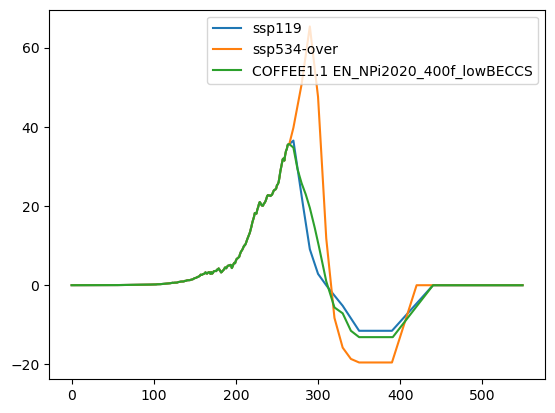

In [14]:
for scenario in scenarios:
    pl.plot(f.emissions.loc[dict(specie='CO2 FFI', config=valid_all[0], scenario=scenario)], label=scenario)
pl.legend()

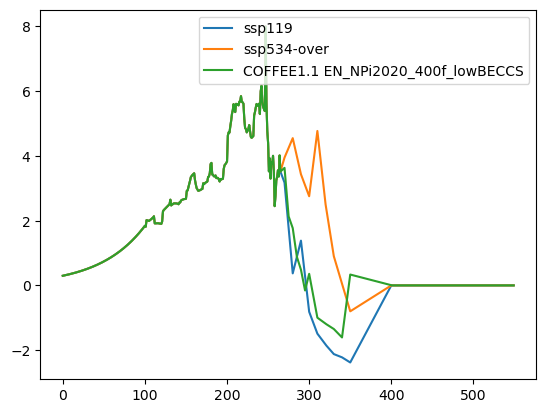

In [15]:
for scenario in scenarios:
    pl.plot(f.emissions.loc[dict(specie='CO2 AFOLU', config=valid_all[0], scenario=scenario)], label=scenario)
pl.legend()

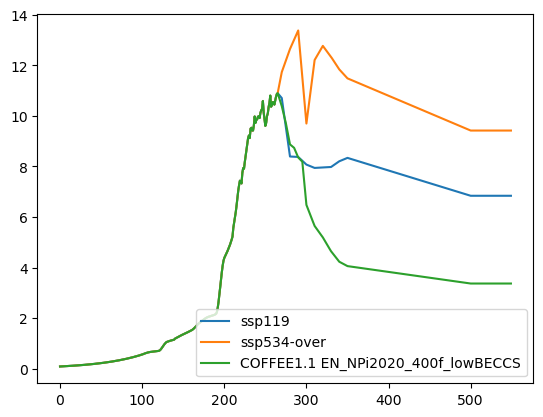

In [16]:
for scenario in scenarios:
    pl.plot(f.emissions.loc[dict(specie='N2O', config=valid_all[0], scenario=scenario)], label=scenario)
pl.legend()

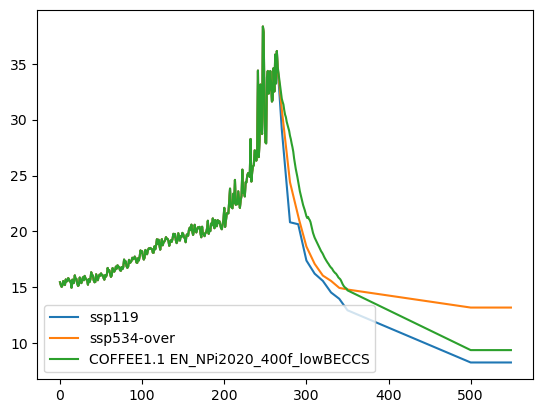

In [17]:
for scenario in scenarios:
    pl.plot(f.emissions.loc[dict(specie='OC', config=valid_all[0], scenario=scenario)], label=scenario)
pl.legend()

In [18]:
# solar and volcanic forcing
fill(
    f.forcing,
    volcanic_forcing[:, None, None] * df_configs.loc[valid_all, "fscale_Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    solar_forcing[:, None, None] * df_configs.loc[valid_all, "fscale_solar_amplitude"].values.squeeze()
    + trend_shape[:, None, None] * df_configs.loc[valid_all, "fscale_solar_trend"].values.squeeze(),
    specie="Solar",
)

# climate response
fill(f.climate_configs["ocean_heat_capacity"], df_configs.loc[valid_all, "clim_c1":"clim_c3"].values)
fill(
    f.climate_configs["ocean_heat_transfer"],
    df_configs.loc[valid_all, "clim_kappa1":"clim_kappa3"].values,
)
fill(f.climate_configs["deep_ocean_efficacy"], df_configs.loc[valid_all,"clim_epsilon"].values.squeeze())
fill(f.climate_configs["gamma_autocorrelation"], df_configs.loc[valid_all,"clim_gamma"].values.squeeze())
fill(f.climate_configs["sigma_eta"], df_configs.loc[valid_all,"clim_sigma_eta"].values.squeeze())
fill(f.climate_configs["sigma_xi"], df_configs.loc[valid_all,"clim_sigma_xi"].values.squeeze())
fill(f.climate_configs["seed"], df_configs.loc[valid_all,"seed"])
fill(f.climate_configs["stochastic_run"], False)
fill(f.climate_configs["use_seed"], True)
fill(f.climate_configs["forcing_4co2"], df_configs.loc[valid_all,"clim_F_4xCO2"])

# species level
f.fill_species_configs()

# carbon cycle
fill(f.species_configs["iirf_0"], df_configs.loc[valid_all,"cc_r0"].values.squeeze(), specie="CO2")
fill(
    f.species_configs["iirf_airborne"], df_configs.loc[valid_all,"cc_rA"].values.squeeze(), specie="CO2"
)
fill(f.species_configs["iirf_uptake"], df_configs.loc[valid_all,"cc_rU"].values.squeeze(), specie="CO2")
fill(
    f.species_configs["iirf_temperature"],
    df_configs.loc[valid_all,"cc_rT"].values.squeeze(),
    specie="CO2",
)

# aerosol indirect
fill(f.species_configs["aci_scale"], df_configs.loc[valid_all,"aci_beta"].values.squeeze())
fill(
    f.species_configs["aci_shape"],
    df_configs.loc[valid_all,"aci_shape_so2"].values.squeeze(),
    specie="Sulfur",
)
fill(
    f.species_configs["aci_shape"], df_configs.loc[valid_all,"aci_shape_bc"].values.squeeze(), specie="BC"
)
fill(
    f.species_configs["aci_shape"], df_configs.loc[valid_all,"aci_shape_oc"].values.squeeze(), specie="OC"
)

# methane lifetime baseline and sensitivity
fill(
    f.species_configs["unperturbed_lifetime"],
    df_methane.loc["historical_best", "base"],
    specie="CH4",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "CH4"],
    specie="CH4",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "N2O"],
    specie="N2O",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "VOC"],
    specie="VOC",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "NOx"],
    specie="NOx",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "HC"],
    specie="Equivalent effective stratospheric chlorine",
)
fill(
    f.species_configs["lifetime_temperature_sensitivity"],
    df_methane.loc["historical_best", "temp"],
)

# emissions adjustments for N2O and CH4 (we don't want to make these defaults as people
# might wanna run pulse expts with these gases)
fill(f.species_configs["baseline_emissions"], 19.019783117809567, specie="CH4")
fill(f.species_configs["baseline_emissions"], 0.08602230754, specie="N2O")
fill(f.species_configs["baseline_emissions"], 19.423526730206152, specie="NOx")

# aerosol direct
for specie in [
    "BC",
    "CH4",
    "N2O",
    "NH3",
    "NOx",
    "OC",
    "Sulfur",
    "VOC",
    "Equivalent effective stratospheric chlorine",
]:
    fill(
        f.species_configs["erfari_radiative_efficiency"],
        df_configs.loc[valid_all,f"ari_{specie}"],
        specie=specie,
    )

# forcing scaling
for specie in [
    "CO2",
    "CH4",
    "N2O",
    "Stratospheric water vapour",
    "Light absorbing particles on snow and ice",
    "Land use",
]:
    fill(
        f.species_configs["forcing_scale"],
        df_configs.loc[valid_all,f"fscale_{specie}"].values.squeeze(),
        specie=specie,
    )

for specie in [
    "CFC-11",
    "CFC-12",
    "CFC-113",
    "CFC-114",
    "CFC-115",
    "HCFC-22",
    "HCFC-141b",
    "HCFC-142b",
    "CCl4",
    "CHCl3",
    "CH2Cl2",
    "CH3Cl",
    "CH3CCl3",
    "CH3Br",
    "Halon-1211",
    "Halon-1301",
    "Halon-2402",
    "CF4",
    "C2F6",
    "C3F8",
    "c-C4F8",
    "C4F10",
    "C5F12",
    "C6F14",
    "C7F16",
    "C8F18",
    "NF3",
    "SF6",
    "SO2F2",
    "HFC-125",
    "HFC-134a",
    "HFC-143a",
    "HFC-152a",
    "HFC-227ea",
    "HFC-23",
    "HFC-236fa",
    "HFC-245fa",
    "HFC-32",
    "HFC-365mfc",
    "HFC-4310mee",
]:
    fill(
        f.species_configs["forcing_scale"],
        df_configs.loc[valid_all,"fscale_minorGHG"].values.squeeze(),
        specie=specie,
    )

# ozone
for specie in [
    "CH4",
    "N2O",
    "Equivalent effective stratospheric chlorine",
    "CO",
    "VOC",
    "NOx",
]:
    fill(
        f.species_configs["ozone_radiative_efficiency"],
        df_configs.loc[valid_all,f"o3_{specie}"],
        specie=specie,
    )

# tune down volcanic efficacy
fill(f.species_configs["forcing_efficacy"], 0.6, specie="Volcanic")


# initial condition of CO2 concentration (but not baseline for forcing calculations)
fill(
    f.species_configs["baseline_concentration"],
    df_configs.loc[valid_all,"cc_co2_concentration_1750"].values.squeeze(),
    specie="CO2",
)

initialise(f.concentration, f.species_configs['baseline_concentration'])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.airborne_emissions, 0)
initialise(f.cumulative_emissions, 0)

f.run()

Running 2523 projections in parallel:   0%|          | 0/550 [00:00<?, ?timesteps/s]

In [19]:
temp_norm_20032022 = np.ones(21)
temp_norm_20032022[0] = 0.5
temp_norm_20032022[-1] = 0.5

In [20]:
df_gmst = pd.read_csv('../data/constraints/IGCC_GMST_1850-2022.csv', index_col=0)

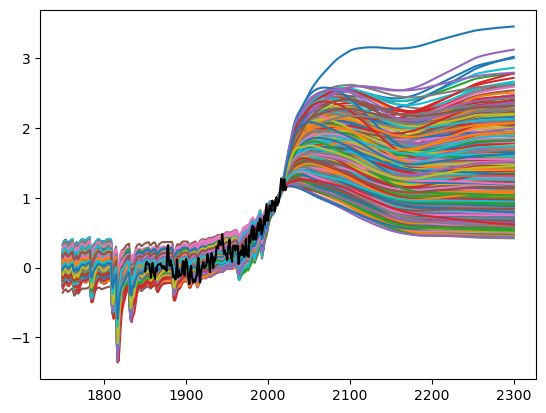

In [21]:
# ssp119
pl.plot(
    np.arange(1750, 2301),
    f.temperature[:, 0, :, 0].values - 
    np.average(f.temperature[253:274, 0, :, 0].values, axis=0, weights=temp_norm_20032022) + 1.03
);
pl.plot(df_gmst.gmst, color='k')
#pl.xlim(1995, 2050)
#pl.ylim(0.5, 1.8)

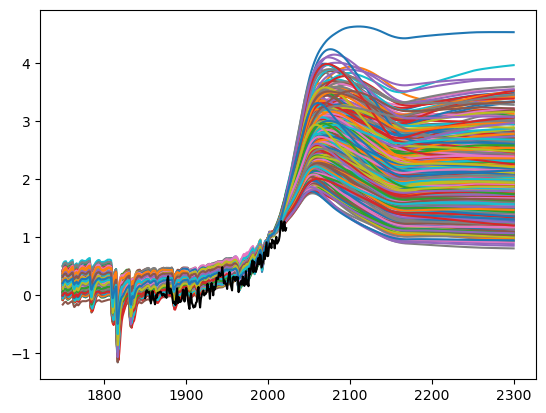

In [22]:
# ssp534
pl.plot(
    np.arange(1750, 2301),
    f.temperature[:, 1, :, 0].values - 
    np.average(f.temperature[245:266, 1, :, 0].values, axis=0, weights=temp_norm_20032022) + 1.03
);
pl.plot(df_gmst.gmst, color='k')

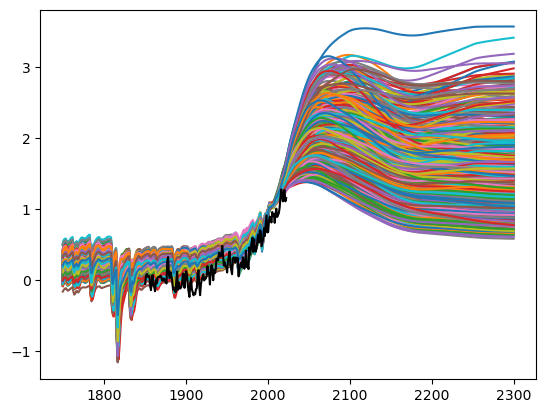

In [23]:
# coffee
pl.plot(
    np.arange(1750, 2301),
    f.temperature[:, 2, :, 0].values - 
    np.average(f.temperature[245:266, 2, :, 0].values, axis=0, weights=temp_norm_20032022) + 1.03
);
pl.plot(df_gmst.gmst, color='k')

In [24]:
# first index of 1.5C exceedence. If zero, run stays under 1.5C
exceeds_1p5_indices = np.argmax(
    f.temperature[:, :, :, 0].values - 
    np.average(f.temperature[245:266, 0, :, 0].values, axis=0, weights=temp_norm_20032022) + 1.03 > 1.5,
    axis=0
)
exceeds_1p5_indices

array([[272, 270, 287, ..., 272, 278, 270],
       [272, 269, 281, ..., 272, 275, 270],
       [273, 270, 287, ..., 273, 277, 271]])

In [25]:
# how many ensemble members exceed 1.5?
print(exceeds_1p5_indices[0, exceeds_1p5_indices[0, :]>0].shape)
print(exceeds_1p5_indices[1, exceeds_1p5_indices[1, :]>0].shape)
print(exceeds_1p5_indices[2, exceeds_1p5_indices[2, :]>0].shape)

(730,)
(841,)
(817,)


In [26]:
# Check first year of exceeding 1.5C
print(np.min(exceeds_1p5_indices[0, exceeds_1p5_indices[0, :]>0]))
print(np.min(exceeds_1p5_indices[1, exceeds_1p5_indices[1, :]>0]))
print(np.min(exceeds_1p5_indices[2, exceeds_1p5_indices[2, :]>0]))

268
268
268


In [27]:
# does the config exceed 1.5C?
run_exceeds_1p5 = np.zeros_like(exceeds_1p5_indices, dtype=bool)
run_exceeds_1p5[exceeds_1p5_indices > 0] = True
run_exceeds_1p5

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [28]:
np.sum(run_exceeds_1p5)

2388

In [29]:
f_fut = {}

In [30]:
f_fut[2023] = FAIR(ch4_method="Thornhill2021")

In [31]:
f_fut[2023].define_time(1750, 2024, 1)

In [32]:
f_fut[2023].define_scenarios(scenarios)

In [33]:
species, properties = read_properties()
species.remove("Halon-1202")
species.remove("NOx aviation")
species.remove("Contrails")

In [34]:
f_fut[2023].define_species(species, properties)

In [35]:
f_fut[2023].define_configs(valid_all)

In [36]:
f_fut[2023].allocate()

In [37]:
# add in emissions
for specie in ssp119.index.drop('NOx aviation').drop('Halon-1202'):
    f_fut[2023].emissions.loc[dict(scenario='ssp119', specie=specie)] = ssp119.loc[specie, :].interpolate().values[:274][:, None]
for specie in ssp534.index.drop('NOx aviation').drop('Halon-1202'):
    f_fut[2023].emissions.loc[dict(scenario='ssp534-over', specie=specie)] = ssp534.loc[specie, :].interpolate().values[:274][:, None]
for specie in coffee.index.drop('NOx aviation').drop('Halon-1202'):
    f_fut[2023].emissions.loc[dict(scenario='COFFEE1.1 EN_NPi2020_400f_lowBECCS', specie=specie)] = coffee.loc[specie, :].interpolate().values[:274][:, None]

In [38]:
# solar and volcanic forcing
fill(
    f_fut[2023].forcing,
    volcanic_forcing[:275, None, None] * df_configs.loc[valid_all, "fscale_Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f_fut[2023].forcing,
    solar_forcing[:275, None, None] * df_configs.loc[valid_all, "fscale_solar_amplitude"].values.squeeze()
    + trend_shape[:275, None, None] * df_configs.loc[valid_all, "fscale_solar_trend"].values.squeeze(),
    specie="Solar",
)

# climate response
fill(f_fut[2023].climate_configs["ocean_heat_capacity"], df_configs.loc[valid_all, "clim_c1":"clim_c3"].values)
fill(
    f_fut[2023].climate_configs["ocean_heat_transfer"],
    df_configs.loc[valid_all, "clim_kappa1":"clim_kappa3"].values,
)
fill(f_fut[2023].climate_configs["deep_ocean_efficacy"], df_configs.loc[valid_all, "clim_epsilon"])
fill(f_fut[2023].climate_configs["gamma_autocorrelation"], df_configs.loc[valid_all, "clim_gamma"])
fill(f_fut[2023].climate_configs["sigma_eta"], df_configs.loc[valid_all, "clim_sigma_eta"])
fill(f_fut[2023].climate_configs["sigma_xi"], df_configs.loc[valid_all, "clim_sigma_xi"])
fill(f_fut[2023].climate_configs["seed"], df_configs.loc[valid_all, "seed"])
fill(f_fut[2023].climate_configs["stochastic_run"], False)
fill(f_fut[2023].climate_configs["use_seed"], True)
fill(f_fut[2023].climate_configs["forcing_4co2"], df_configs.loc[valid_all, "clim_F_4xCO2"])

# species level
f_fut[2023].fill_species_configs()

# carbon cycle
fill(f_fut[2023].species_configs["iirf_0"], df_configs.loc[valid_all,"cc_r0"], specie="CO2")
fill(
    f_fut[2023].species_configs["iirf_airborne"], df_configs.loc[valid_all,"cc_rA"], specie="CO2"
)
fill(f_fut[2023].species_configs["iirf_uptake"], df_configs.loc[valid_all,"cc_rU"], specie="CO2")
fill(
    f_fut[2023].species_configs["iirf_temperature"],
    df_configs.loc[valid_all,"cc_rT"],
    specie="CO2",
)

# aerosol indirect
fill(f_fut[2023].species_configs["aci_scale"], df_configs.loc[valid_all,"aci_beta"])
fill(
    f_fut[2023].species_configs["aci_shape"],
    df_configs.loc[valid_all, "aci_shape_so2"],
    specie="Sulfur",
)
fill(
    f_fut[2023].species_configs["aci_shape"], df_configs.loc[valid_all, "aci_shape_bc"], specie="BC"
)
fill(
    f_fut[2023].species_configs["aci_shape"], df_configs.loc[valid_all, "aci_shape_oc"], specie="OC"
)

# methane lifetime baseline and sensitivity
fill(
    f_fut[2023].species_configs["unperturbed_lifetime"],
    df_methane.loc["historical_best", "base"],
    specie="CH4",
)
fill(
    f_fut[2023].species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "CH4"],
    specie="CH4",
)
fill(
    f_fut[2023].species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "N2O"],
    specie="N2O",
)
fill(
    f_fut[2023].species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "VOC"],
    specie="VOC",
)
fill(
    f_fut[2023].species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "NOx"],
    specie="NOx",
)
fill(
    f_fut[2023].species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "HC"],
    specie="Equivalent effective stratospheric chlorine",
)
fill(
    f_fut[2023].species_configs["lifetime_temperature_sensitivity"],
    df_methane.loc["historical_best", "temp"],
)

# emissions adjustments for N2O and CH4 (we don't want to make these defaults as people
# might wanna run pulse expts with these gases)
fill(f_fut[2023].species_configs["baseline_emissions"], 19.019783117809567, specie="CH4")
fill(f_fut[2023].species_configs["baseline_emissions"], 0.08602230754, specie="N2O")
fill(f_fut[2023].species_configs["baseline_emissions"], 19.423526730206152, specie="NOx")

# aerosol direct
for specie in [
    "BC",
    "CH4",
    "N2O",
    "NH3",
    "NOx",
    "OC",
    "Sulfur",
    "VOC",
    "Equivalent effective stratospheric chlorine",
]:
    fill(
        f_fut[2023].species_configs["erfari_radiative_efficiency"],
        df_configs.loc[valid_all, f"ari_{specie}"],
        specie=specie,
    )

# forcing scaling
for specie in [
    "CO2",
    "CH4",
    "N2O",
    "Stratospheric water vapour",
    "Light absorbing particles on snow and ice",
    "Land use",
]:
    fill(
        f_fut[2023].species_configs["forcing_scale"],
        df_configs.loc[valid_all, f"fscale_{specie}"],
        specie=specie,
    )

for specie in [
    "CFC-11",
    "CFC-12",
    "CFC-113",
    "CFC-114",
    "CFC-115",
    "HCFC-22",
    "HCFC-141b",
    "HCFC-142b",
    "CCl4",
    "CHCl3",
    "CH2Cl2",
    "CH3Cl",
    "CH3CCl3",
    "CH3Br",
    "Halon-1211",
    "Halon-1301",
    "Halon-2402",
    "CF4",
    "C2F6",
    "C3F8",
    "c-C4F8",
    "C4F10",
    "C5F12",
    "C6F14",
    "C7F16",
    "C8F18",
    "NF3",
    "SF6",
    "SO2F2",
    "HFC-125",
    "HFC-134a",
    "HFC-143a",
    "HFC-152a",
    "HFC-227ea",
    "HFC-23",
    "HFC-236fa",
    "HFC-245fa",
    "HFC-32",
    "HFC-365mfc",
    "HFC-4310mee",
]:
    fill(
        f_fut[2023].species_configs["forcing_scale"],
        df_configs.loc[valid_all,"fscale_minorGHG"].values.squeeze(),
        specie=specie,
    )

# ozone
for specie in [
    "CH4",
    "N2O",
    "Equivalent effective stratospheric chlorine",
    "CO",
    "VOC",
    "NOx",
]:
    fill(
        f_fut[2023].species_configs["ozone_radiative_efficiency"],
        df_configs.loc[valid_all, f"o3_{specie}"],
        specie=specie,
    )

# tune down volcanic efficacy
fill(f_fut[2023].species_configs["forcing_efficacy"], 0.6, specie="Volcanic")


# initial condition of CO2 concentration (but not baseline for forcing calculations)
fill(
    f_fut[2023].species_configs["baseline_concentration"],
    df_configs.loc[valid_all,"cc_co2_concentration_1750"],
    specie="CO2",
)

initialise(f_fut[2023].concentration, f_fut[2023].species_configs['baseline_concentration'])
initialise(f_fut[2023].forcing, 0)
initialise(f_fut[2023].temperature, 0)
initialise(f_fut[2023].airborne_emissions, 0)
initialise(f_fut[2023].cumulative_emissions, 0)

f_fut[2023].run()

Running 2523 projections in parallel:   0%|          | 0/274 [00:00<?, ?timesteps/s]

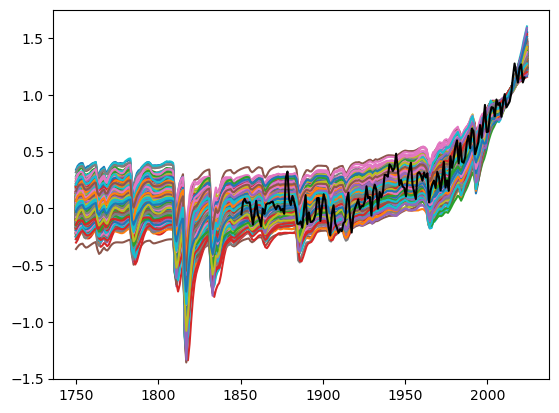

In [39]:
#pl.plot(f_fut[2023].temperature[:,0,:,0]);
pl.plot(
    np.arange(1750, 2025),
    f_fut[2023].temperature[:, 0, :, 0].values - 
    np.average(f_fut[2023].temperature[253:274, 0, :, 0].values, axis=0, weights=temp_norm_20032022) + 1.03
);
pl.plot(df_gmst.gmst, color='k')

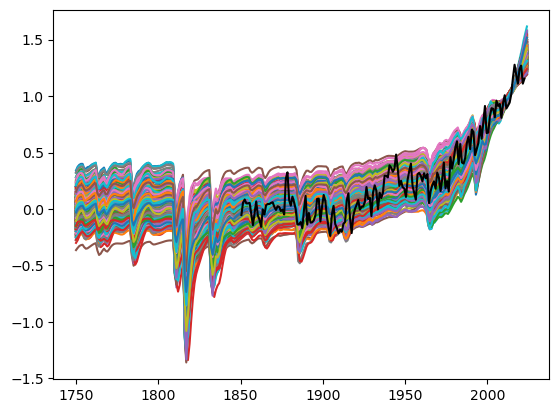

In [40]:
#pl.plot(f_fut[2023].temperature[:,1,:,0]);
pl.plot(
    np.arange(1750, 2025),
    f_fut[2023].temperature[:, 1, :, 0].values - 
    np.average(f_fut[2023].temperature[253:274, 1, :, 0].values, axis=0, weights=temp_norm_20032022) + 1.03
);
pl.plot(df_gmst.gmst, color='k')

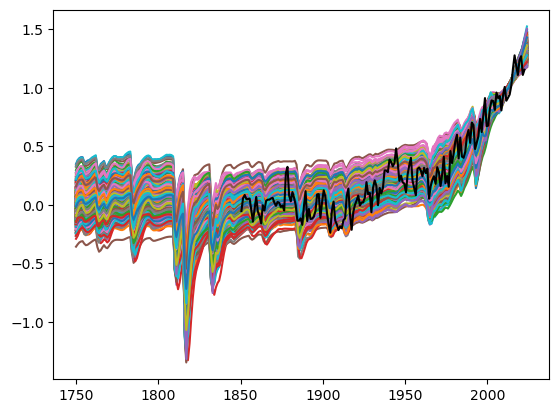

In [41]:
pl.plot(
    np.arange(1750, 2025),
    f_fut[2023].temperature[:, 2, :, 0].values - 
    np.average(f_fut[2023].temperature[253:274, 2, :, 0].values, axis=0, weights=temp_norm_20032022) + 1.03
);
pl.plot(df_gmst.gmst, color='k')

These following three diagnositc plots should be zero else the runs are not compatible.

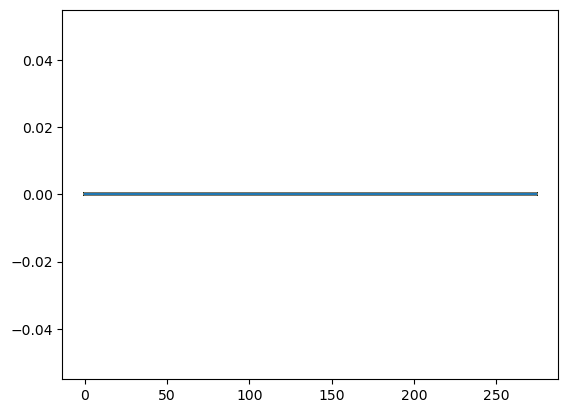

In [42]:
pl.plot(f_fut[2023].temperature[:, 0, :, 0].values - f.temperature[:275, 0, :, 0].values);

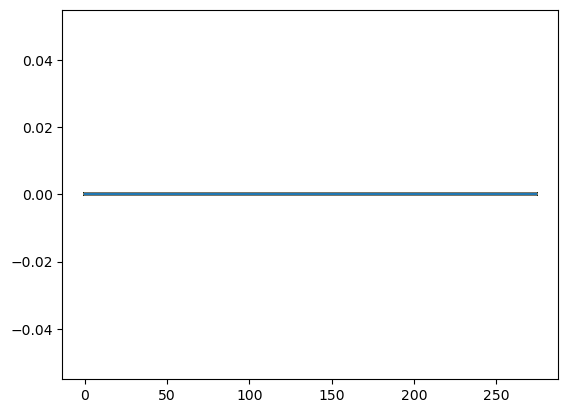

In [43]:
pl.plot(f_fut[2023].temperature[:, 1, :, 0].values - f.temperature[:275, 1, :, 0].values);

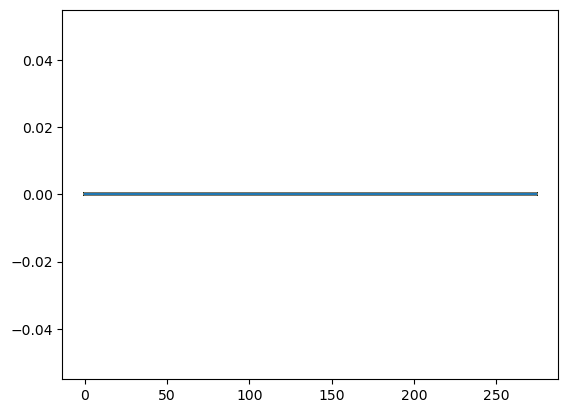

In [44]:
pl.plot(f_fut[2023].temperature[:, 2, :, 0].values - f.temperature[:275, 2, :, 0].values);

In [45]:
for year in tqdm(range(2024, 2300)):
    run = 0
    f_fut[year] = FAIR(ch4_method="Thornhill2021")
    f_fut[year].define_time(year, year+1, 1)
    f_fut[year].define_scenarios(scenarios)
    f_fut[year].define_species(species, properties)
    f_fut[year].define_configs(valid_all)
    f_fut[year].allocate()
    
    # emissions in
    for specie in ssp119.index.drop('NOx aviation').drop('Halon-1202'):
        f_fut[year].emissions.loc[dict(scenario='ssp119', specie=specie)] = ssp119.loc[specie, :].interpolate().values[year-1750]
    for specie in ssp534.index.drop('NOx aviation').drop('Halon-1202'):
        f_fut[year].emissions.loc[dict(scenario='ssp534-over', specie=specie)] = ssp534.loc[specie, :].interpolate().values[year-1750]
    for specie in coffee.index.drop('NOx aviation').drop('Halon-1202'):
        f_fut[year].emissions.loc[dict(scenario='COFFEE1.1 EN_NPi2020_400f_lowBECCS', specie=specie)] = coffee.loc[specie, :].interpolate().values[year-1750]
    
    # climate response
    fill(f_fut[year].climate_configs["ocean_heat_capacity"], df_configs.loc[valid_all, "clim_c1":"clim_c3"].values)
    fill(
        f_fut[year].climate_configs["ocean_heat_transfer"],
        df_configs.loc[valid_all, "clim_kappa1":"clim_kappa3"].values,
    )
    fill(f_fut[year].climate_configs["deep_ocean_efficacy"], df_configs.loc[valid_all, "clim_epsilon"])
    fill(f_fut[year].climate_configs["gamma_autocorrelation"], df_configs.loc[valid_all, "clim_gamma"])
    fill(f_fut[year].climate_configs["sigma_eta"], df_configs.loc[valid_all, "clim_sigma_eta"])
    fill(f_fut[year].climate_configs["sigma_xi"], df_configs.loc[valid_all, "clim_sigma_xi"])
    fill(f_fut[year].climate_configs["seed"], df_configs.loc[valid_all, "seed"])
    fill(f_fut[year].climate_configs["stochastic_run"], False)
    fill(f_fut[year].climate_configs["use_seed"], True)
    fill(f_fut[year].climate_configs["forcing_4co2"], df_configs.loc[valid_all, "clim_F_4xCO2"])

    # species level
    f_fut[year].fill_species_configs()

    # carbon cycle
    fill(f_fut[year].species_configs["iirf_0"], df_configs.loc[valid_all,"cc_r0"], specie="CO2")
    fill(
        f_fut[year].species_configs["iirf_airborne"], df_configs.loc[valid_all,"cc_rA"], specie="CO2"
    )
    fill(f_fut[year].species_configs["iirf_uptake"], df_configs.loc[valid_all,"cc_rU"], specie="CO2")
    fill(
        f_fut[year].species_configs["iirf_temperature"],
        df_configs.loc[valid_all,"cc_rT"],
        specie="CO2",
    )

    # aerosol indirect
    fill(f_fut[year].species_configs["aci_scale"], df_configs.loc[valid_all,"aci_beta"])
    fill(
        f_fut[year].species_configs["aci_shape"],
        df_configs.loc[valid_all, "aci_shape_so2"],
        specie="Sulfur",
    )
    fill(
        f_fut[year].species_configs["aci_shape"], df_configs.loc[valid_all, "aci_shape_bc"], specie="BC"
    )
    fill(
        f_fut[year].species_configs["aci_shape"], df_configs.loc[valid_all, "aci_shape_oc"], specie="OC"
    )

    # methane lifetime baseline and sensitivity
    fill(
        f_fut[year].species_configs["unperturbed_lifetime"],
        df_methane.loc["historical_best", "base"],
        specie="CH4",
    )
    fill(
        f_fut[year].species_configs["ch4_lifetime_chemical_sensitivity"],
        df_methane.loc["historical_best", "CH4"],
        specie="CH4",
    )
    fill(
        f_fut[year].species_configs["ch4_lifetime_chemical_sensitivity"],
        df_methane.loc["historical_best", "N2O"],
        specie="N2O",
    )
    fill(
        f_fut[year].species_configs["ch4_lifetime_chemical_sensitivity"],
        df_methane.loc["historical_best", "VOC"],
        specie="VOC",
    )
    fill(
        f_fut[year].species_configs["ch4_lifetime_chemical_sensitivity"],
        df_methane.loc["historical_best", "NOx"],
        specie="NOx",
    )
    fill(
        f_fut[year].species_configs["ch4_lifetime_chemical_sensitivity"],
        df_methane.loc["historical_best", "HC"],
        specie="Equivalent effective stratospheric chlorine",
    )
    fill(
        f_fut[year].species_configs["lifetime_temperature_sensitivity"],
        df_methane.loc["historical_best", "temp"],
    )

    # emissions adjustments for N2O and CH4 (we don't want to make these defaults as people
    # might wanna run pulse expts with these gases)
    fill(f_fut[year].species_configs["baseline_emissions"], 19.019783117809567, specie="CH4")
    fill(f_fut[year].species_configs["baseline_emissions"], 0.08602230754, specie="N2O")
    fill(f_fut[year].species_configs["baseline_emissions"], 19.423526730206152, specie="NOx")

    # aerosol direct
    for specie in [
        "BC",
        "CH4",
        "N2O",
        "NH3",
        "NOx",
        "OC",
        "Sulfur",
        "VOC",
        "Equivalent effective stratospheric chlorine",
    ]:
        fill(
            f_fut[year].species_configs["erfari_radiative_efficiency"],
            df_configs.loc[valid_all, f"ari_{specie}"],
            specie=specie,
        )

    # forcing scaling
    for specie in [
        "CO2",
        "CH4",
        "N2O",
        "Stratospheric water vapour",
        "Light absorbing particles on snow and ice",
        "Land use",
    ]:
        fill(
            f_fut[year].species_configs["forcing_scale"],
            df_configs.loc[valid_all, f"fscale_{specie}"],
            specie=specie,
        )

    for specie in [
        "CFC-11",
        "CFC-12",
        "CFC-113",
        "CFC-114",
        "CFC-115",
        "HCFC-22",
        "HCFC-141b",
        "HCFC-142b",
        "CCl4",
        "CHCl3",
        "CH2Cl2",
        "CH3Cl",
        "CH3CCl3",
        "CH3Br",
        "Halon-1211",
        "Halon-1301",
        "Halon-2402",
        "CF4",
        "C2F6",
        "C3F8",
        "c-C4F8",
        "C4F10",
        "C5F12",
        "C6F14",
        "C7F16",
        "C8F18",
        "NF3",
        "SF6",
        "SO2F2",
        "HFC-125",
        "HFC-134a",
        "HFC-143a",
        "HFC-152a",
        "HFC-227ea",
        "HFC-23",
        "HFC-236fa",
        "HFC-245fa",
        "HFC-32",
        "HFC-365mfc",
        "HFC-4310mee",
    ]:
        fill(
            f_fut[year].species_configs["forcing_scale"],
            df_configs.loc[valid_all,"fscale_minorGHG"],
            specie=specie,
        )

    # ozone
    for specie in [
        "CH4",
        "N2O",
        "Equivalent effective stratospheric chlorine",
        "CO",
        "VOC",
        "NOx",
    ]:
        fill(
            f_fut[year].species_configs["ozone_radiative_efficiency"],
            df_configs.loc[valid_all, f"o3_{specie}"],
            specie=specie,
        )

    # tune down volcanic efficacy
    fill(f_fut[year].species_configs["forcing_efficacy"], 0.6, specie="Volcanic")


    # initial condition of CO2 concentration (but not baseline for forcing calculations)
    fill(
        f_fut[year].species_configs["baseline_concentration"],
        df_configs.loc[valid_all,"cc_co2_concentration_1750"],
        specie="CO2",
    )

    progress = tqdm(position=1, desc=f"running adaptive removal in {year}", leave=False)
    while True:
        progress.update()
        run = run+1
        initialise(f_fut[year].concentration, f_fut[year-1].concentration[-1, ...])
        initialise(f_fut[year].forcing, f_fut[year-1].forcing[-1, ...])
        initialise(f_fut[year].temperature, f_fut[year-1].temperature[-1, ...])
        initialise(f_fut[year].airborne_emissions, f_fut[year-1].airborne_emissions[-1, ...])
        initialise(f_fut[year].cumulative_emissions, f_fut[year-1].cumulative_emissions[-1, ...])
        initialise(f_fut[year].alpha_lifetime, f_fut[year-1].alpha_lifetime[-1, ...])
        f_fut[year].gas_partitions=copy.deepcopy(f_fut[year-1].gas_partitions)
        
        # Volcanic forcing
        fill(
            f_fut[year].forcing, 
            volcanic_forcing[year-1750:year-1749, None, None] * 
            df_configs.loc[valid_all, 'fscale_Volcanic'].values.squeeze(), 
            specie='Volcanic'
        )

        # Solar forcing
        fill(f_fut[year].forcing, 
             solar_forcing[year-1750:year-1749, None, None] * 
             df_configs.loc[valid_all, 'fscale_solar_amplitude'].values.squeeze() + 
             trend_shape[year-1750:year-1749, None, None] * df_configs.loc[valid_all, 'fscale_solar_trend'].values.squeeze(),
             specie='Solar'
        )

        # do the run
        f_fut[year].run(progress=False)
        
        # naive optimizer!
        t_anom = (f_fut[year].temperature[-1, :, :, 0] - np.average(f_fut[2023].temperature[253:274, :, :, 0], weights=temp_norm_20032022, axis=0)) + 1.03
        c_ch4 = f_fut[year].concentration[-1, :, :, 3]
        
        #print(f"temperature in {year} is {t_anom.values}")
        overshoot_configs = np.logical_and(t_anom>1.5, c_ch4>50)
        # print(np.sum(overshoot_configs).values)
        
        # all below 1.5C? great; move on to next year, else continue
        if np.sum(overshoot_configs).values==0:# or run>=100:
            break
        
        shave = np.zeros_like(t_anom)
        #shave[overshoot_configs] = np.maximum(10, (t_anom.values[overshoot_configs]-1.5)*10000)
        shave[overshoot_configs] = 20
        f_fut[year].emissions[0, :, :, 3] = f_fut[year].emissions[0, :, :, 3] - shave

  0%|          | 0/276 [00:00<?, ?it/s]

running adaptive removal in 2024: 0it [00:00, ?it/s]

running adaptive removal in 2025: 0it [00:00, ?it/s]

running adaptive removal in 2026: 0it [00:00, ?it/s]

running adaptive removal in 2027: 0it [00:00, ?it/s]

running adaptive removal in 2028: 0it [00:00, ?it/s]

running adaptive removal in 2029: 0it [00:00, ?it/s]

running adaptive removal in 2030: 0it [00:00, ?it/s]

running adaptive removal in 2031: 0it [00:00, ?it/s]

running adaptive removal in 2032: 0it [00:00, ?it/s]

running adaptive removal in 2033: 0it [00:00, ?it/s]

running adaptive removal in 2034: 0it [00:00, ?it/s]

running adaptive removal in 2035: 0it [00:00, ?it/s]

running adaptive removal in 2036: 0it [00:00, ?it/s]

running adaptive removal in 2037: 0it [00:00, ?it/s]

running adaptive removal in 2038: 0it [00:00, ?it/s]

running adaptive removal in 2039: 0it [00:00, ?it/s]

running adaptive removal in 2040: 0it [00:00, ?it/s]

running adaptive removal in 2041: 0it [00:00, ?it/s]

running adaptive removal in 2042: 0it [00:00, ?it/s]

running adaptive removal in 2043: 0it [00:00, ?it/s]

running adaptive removal in 2044: 0it [00:00, ?it/s]

running adaptive removal in 2045: 0it [00:00, ?it/s]

running adaptive removal in 2046: 0it [00:00, ?it/s]

running adaptive removal in 2047: 0it [00:00, ?it/s]

running adaptive removal in 2048: 0it [00:00, ?it/s]

running adaptive removal in 2049: 0it [00:00, ?it/s]

running adaptive removal in 2050: 0it [00:00, ?it/s]

running adaptive removal in 2051: 0it [00:00, ?it/s]

running adaptive removal in 2052: 0it [00:00, ?it/s]

running adaptive removal in 2053: 0it [00:00, ?it/s]

running adaptive removal in 2054: 0it [00:00, ?it/s]

running adaptive removal in 2055: 0it [00:00, ?it/s]

running adaptive removal in 2056: 0it [00:00, ?it/s]

running adaptive removal in 2057: 0it [00:00, ?it/s]

running adaptive removal in 2058: 0it [00:00, ?it/s]

running adaptive removal in 2059: 0it [00:00, ?it/s]

running adaptive removal in 2060: 0it [00:00, ?it/s]

running adaptive removal in 2061: 0it [00:00, ?it/s]

running adaptive removal in 2062: 0it [00:00, ?it/s]

running adaptive removal in 2063: 0it [00:00, ?it/s]

running adaptive removal in 2064: 0it [00:00, ?it/s]

running adaptive removal in 2065: 0it [00:00, ?it/s]

running adaptive removal in 2066: 0it [00:00, ?it/s]

running adaptive removal in 2067: 0it [00:00, ?it/s]

running adaptive removal in 2068: 0it [00:00, ?it/s]

running adaptive removal in 2069: 0it [00:00, ?it/s]

running adaptive removal in 2070: 0it [00:00, ?it/s]

running adaptive removal in 2071: 0it [00:00, ?it/s]

running adaptive removal in 2072: 0it [00:00, ?it/s]

running adaptive removal in 2073: 0it [00:00, ?it/s]

running adaptive removal in 2074: 0it [00:00, ?it/s]

running adaptive removal in 2075: 0it [00:00, ?it/s]

running adaptive removal in 2076: 0it [00:00, ?it/s]

running adaptive removal in 2077: 0it [00:00, ?it/s]

running adaptive removal in 2078: 0it [00:00, ?it/s]

running adaptive removal in 2079: 0it [00:00, ?it/s]

running adaptive removal in 2080: 0it [00:00, ?it/s]

running adaptive removal in 2081: 0it [00:00, ?it/s]

running adaptive removal in 2082: 0it [00:00, ?it/s]

running adaptive removal in 2083: 0it [00:00, ?it/s]

running adaptive removal in 2084: 0it [00:00, ?it/s]

running adaptive removal in 2085: 0it [00:00, ?it/s]

running adaptive removal in 2086: 0it [00:00, ?it/s]

running adaptive removal in 2087: 0it [00:00, ?it/s]

running adaptive removal in 2088: 0it [00:00, ?it/s]

running adaptive removal in 2089: 0it [00:00, ?it/s]

running adaptive removal in 2090: 0it [00:00, ?it/s]

running adaptive removal in 2091: 0it [00:00, ?it/s]

running adaptive removal in 2092: 0it [00:00, ?it/s]

running adaptive removal in 2093: 0it [00:00, ?it/s]

running adaptive removal in 2094: 0it [00:00, ?it/s]

running adaptive removal in 2095: 0it [00:00, ?it/s]

running adaptive removal in 2096: 0it [00:00, ?it/s]

running adaptive removal in 2097: 0it [00:00, ?it/s]

running adaptive removal in 2098: 0it [00:00, ?it/s]

running adaptive removal in 2099: 0it [00:00, ?it/s]

running adaptive removal in 2100: 0it [00:00, ?it/s]

running adaptive removal in 2101: 0it [00:00, ?it/s]

running adaptive removal in 2102: 0it [00:00, ?it/s]

running adaptive removal in 2103: 0it [00:00, ?it/s]

running adaptive removal in 2104: 0it [00:00, ?it/s]

running adaptive removal in 2105: 0it [00:00, ?it/s]

running adaptive removal in 2106: 0it [00:00, ?it/s]

running adaptive removal in 2107: 0it [00:00, ?it/s]

running adaptive removal in 2108: 0it [00:00, ?it/s]

running adaptive removal in 2109: 0it [00:00, ?it/s]

running adaptive removal in 2110: 0it [00:00, ?it/s]

running adaptive removal in 2111: 0it [00:00, ?it/s]

running adaptive removal in 2112: 0it [00:00, ?it/s]

running adaptive removal in 2113: 0it [00:00, ?it/s]

running adaptive removal in 2114: 0it [00:00, ?it/s]

running adaptive removal in 2115: 0it [00:00, ?it/s]

running adaptive removal in 2116: 0it [00:00, ?it/s]

running adaptive removal in 2117: 0it [00:00, ?it/s]

running adaptive removal in 2118: 0it [00:00, ?it/s]

running adaptive removal in 2119: 0it [00:00, ?it/s]

running adaptive removal in 2120: 0it [00:00, ?it/s]

running adaptive removal in 2121: 0it [00:00, ?it/s]

running adaptive removal in 2122: 0it [00:00, ?it/s]

running adaptive removal in 2123: 0it [00:00, ?it/s]

running adaptive removal in 2124: 0it [00:00, ?it/s]

running adaptive removal in 2125: 0it [00:00, ?it/s]

running adaptive removal in 2126: 0it [00:00, ?it/s]

running adaptive removal in 2127: 0it [00:00, ?it/s]

running adaptive removal in 2128: 0it [00:00, ?it/s]

running adaptive removal in 2129: 0it [00:00, ?it/s]

running adaptive removal in 2130: 0it [00:00, ?it/s]

running adaptive removal in 2131: 0it [00:00, ?it/s]

running adaptive removal in 2132: 0it [00:00, ?it/s]

running adaptive removal in 2133: 0it [00:00, ?it/s]

running adaptive removal in 2134: 0it [00:00, ?it/s]

running adaptive removal in 2135: 0it [00:00, ?it/s]

running adaptive removal in 2136: 0it [00:00, ?it/s]

running adaptive removal in 2137: 0it [00:00, ?it/s]

running adaptive removal in 2138: 0it [00:00, ?it/s]

running adaptive removal in 2139: 0it [00:00, ?it/s]

running adaptive removal in 2140: 0it [00:00, ?it/s]

running adaptive removal in 2141: 0it [00:00, ?it/s]

running adaptive removal in 2142: 0it [00:00, ?it/s]

running adaptive removal in 2143: 0it [00:00, ?it/s]

running adaptive removal in 2144: 0it [00:00, ?it/s]

running adaptive removal in 2145: 0it [00:00, ?it/s]

running adaptive removal in 2146: 0it [00:00, ?it/s]

running adaptive removal in 2147: 0it [00:00, ?it/s]

running adaptive removal in 2148: 0it [00:00, ?it/s]

running adaptive removal in 2149: 0it [00:00, ?it/s]

running adaptive removal in 2150: 0it [00:00, ?it/s]

running adaptive removal in 2151: 0it [00:00, ?it/s]

running adaptive removal in 2152: 0it [00:00, ?it/s]

running adaptive removal in 2153: 0it [00:00, ?it/s]

running adaptive removal in 2154: 0it [00:00, ?it/s]

running adaptive removal in 2155: 0it [00:00, ?it/s]

running adaptive removal in 2156: 0it [00:00, ?it/s]

running adaptive removal in 2157: 0it [00:00, ?it/s]

running adaptive removal in 2158: 0it [00:00, ?it/s]

running adaptive removal in 2159: 0it [00:00, ?it/s]

running adaptive removal in 2160: 0it [00:00, ?it/s]

running adaptive removal in 2161: 0it [00:00, ?it/s]

running adaptive removal in 2162: 0it [00:00, ?it/s]

running adaptive removal in 2163: 0it [00:00, ?it/s]

running adaptive removal in 2164: 0it [00:00, ?it/s]

running adaptive removal in 2165: 0it [00:00, ?it/s]

running adaptive removal in 2166: 0it [00:00, ?it/s]

running adaptive removal in 2167: 0it [00:00, ?it/s]

running adaptive removal in 2168: 0it [00:00, ?it/s]

running adaptive removal in 2169: 0it [00:00, ?it/s]

running adaptive removal in 2170: 0it [00:00, ?it/s]

running adaptive removal in 2171: 0it [00:00, ?it/s]

running adaptive removal in 2172: 0it [00:00, ?it/s]

running adaptive removal in 2173: 0it [00:00, ?it/s]

running adaptive removal in 2174: 0it [00:00, ?it/s]

running adaptive removal in 2175: 0it [00:00, ?it/s]

running adaptive removal in 2176: 0it [00:00, ?it/s]

running adaptive removal in 2177: 0it [00:00, ?it/s]

running adaptive removal in 2178: 0it [00:00, ?it/s]

running adaptive removal in 2179: 0it [00:00, ?it/s]

running adaptive removal in 2180: 0it [00:00, ?it/s]

running adaptive removal in 2181: 0it [00:00, ?it/s]

running adaptive removal in 2182: 0it [00:00, ?it/s]

running adaptive removal in 2183: 0it [00:00, ?it/s]

running adaptive removal in 2184: 0it [00:00, ?it/s]

running adaptive removal in 2185: 0it [00:00, ?it/s]

running adaptive removal in 2186: 0it [00:00, ?it/s]

running adaptive removal in 2187: 0it [00:00, ?it/s]

running adaptive removal in 2188: 0it [00:00, ?it/s]

running adaptive removal in 2189: 0it [00:00, ?it/s]

running adaptive removal in 2190: 0it [00:00, ?it/s]

running adaptive removal in 2191: 0it [00:00, ?it/s]

running adaptive removal in 2192: 0it [00:00, ?it/s]

running adaptive removal in 2193: 0it [00:00, ?it/s]

running adaptive removal in 2194: 0it [00:00, ?it/s]

running adaptive removal in 2195: 0it [00:00, ?it/s]

running adaptive removal in 2196: 0it [00:00, ?it/s]

running adaptive removal in 2197: 0it [00:00, ?it/s]

running adaptive removal in 2198: 0it [00:00, ?it/s]

running adaptive removal in 2199: 0it [00:00, ?it/s]

running adaptive removal in 2200: 0it [00:00, ?it/s]

running adaptive removal in 2201: 0it [00:00, ?it/s]

running adaptive removal in 2202: 0it [00:00, ?it/s]

running adaptive removal in 2203: 0it [00:00, ?it/s]

running adaptive removal in 2204: 0it [00:00, ?it/s]

running adaptive removal in 2205: 0it [00:00, ?it/s]

running adaptive removal in 2206: 0it [00:00, ?it/s]

running adaptive removal in 2207: 0it [00:00, ?it/s]

running adaptive removal in 2208: 0it [00:00, ?it/s]

running adaptive removal in 2209: 0it [00:00, ?it/s]

running adaptive removal in 2210: 0it [00:00, ?it/s]

running adaptive removal in 2211: 0it [00:00, ?it/s]

running adaptive removal in 2212: 0it [00:00, ?it/s]

running adaptive removal in 2213: 0it [00:00, ?it/s]

running adaptive removal in 2214: 0it [00:00, ?it/s]

running adaptive removal in 2215: 0it [00:00, ?it/s]

running adaptive removal in 2216: 0it [00:00, ?it/s]

running adaptive removal in 2217: 0it [00:00, ?it/s]

running adaptive removal in 2218: 0it [00:00, ?it/s]

running adaptive removal in 2219: 0it [00:00, ?it/s]

running adaptive removal in 2220: 0it [00:00, ?it/s]

running adaptive removal in 2221: 0it [00:00, ?it/s]

running adaptive removal in 2222: 0it [00:00, ?it/s]

running adaptive removal in 2223: 0it [00:00, ?it/s]

running adaptive removal in 2224: 0it [00:00, ?it/s]

running adaptive removal in 2225: 0it [00:00, ?it/s]

running adaptive removal in 2226: 0it [00:00, ?it/s]

running adaptive removal in 2227: 0it [00:00, ?it/s]

running adaptive removal in 2228: 0it [00:00, ?it/s]

running adaptive removal in 2229: 0it [00:00, ?it/s]

running adaptive removal in 2230: 0it [00:00, ?it/s]

running adaptive removal in 2231: 0it [00:00, ?it/s]

running adaptive removal in 2232: 0it [00:00, ?it/s]

running adaptive removal in 2233: 0it [00:00, ?it/s]

running adaptive removal in 2234: 0it [00:00, ?it/s]

running adaptive removal in 2235: 0it [00:00, ?it/s]

running adaptive removal in 2236: 0it [00:00, ?it/s]

running adaptive removal in 2237: 0it [00:00, ?it/s]

running adaptive removal in 2238: 0it [00:00, ?it/s]

running adaptive removal in 2239: 0it [00:00, ?it/s]

running adaptive removal in 2240: 0it [00:00, ?it/s]

running adaptive removal in 2241: 0it [00:00, ?it/s]

running adaptive removal in 2242: 0it [00:00, ?it/s]

running adaptive removal in 2243: 0it [00:00, ?it/s]

running adaptive removal in 2244: 0it [00:00, ?it/s]

running adaptive removal in 2245: 0it [00:00, ?it/s]

running adaptive removal in 2246: 0it [00:00, ?it/s]

running adaptive removal in 2247: 0it [00:00, ?it/s]

running adaptive removal in 2248: 0it [00:00, ?it/s]

running adaptive removal in 2249: 0it [00:00, ?it/s]

running adaptive removal in 2250: 0it [00:00, ?it/s]

running adaptive removal in 2251: 0it [00:00, ?it/s]

running adaptive removal in 2252: 0it [00:00, ?it/s]

running adaptive removal in 2253: 0it [00:00, ?it/s]

running adaptive removal in 2254: 0it [00:00, ?it/s]

running adaptive removal in 2255: 0it [00:00, ?it/s]

running adaptive removal in 2256: 0it [00:00, ?it/s]

running adaptive removal in 2257: 0it [00:00, ?it/s]

running adaptive removal in 2258: 0it [00:00, ?it/s]

running adaptive removal in 2259: 0it [00:00, ?it/s]

running adaptive removal in 2260: 0it [00:00, ?it/s]

running adaptive removal in 2261: 0it [00:00, ?it/s]

running adaptive removal in 2262: 0it [00:00, ?it/s]

running adaptive removal in 2263: 0it [00:00, ?it/s]

running adaptive removal in 2264: 0it [00:00, ?it/s]

running adaptive removal in 2265: 0it [00:00, ?it/s]

running adaptive removal in 2266: 0it [00:00, ?it/s]

running adaptive removal in 2267: 0it [00:00, ?it/s]

running adaptive removal in 2268: 0it [00:00, ?it/s]

running adaptive removal in 2269: 0it [00:00, ?it/s]

running adaptive removal in 2270: 0it [00:00, ?it/s]

running adaptive removal in 2271: 0it [00:00, ?it/s]

running adaptive removal in 2272: 0it [00:00, ?it/s]

running adaptive removal in 2273: 0it [00:00, ?it/s]

running adaptive removal in 2274: 0it [00:00, ?it/s]

running adaptive removal in 2275: 0it [00:00, ?it/s]

running adaptive removal in 2276: 0it [00:00, ?it/s]

running adaptive removal in 2277: 0it [00:00, ?it/s]

running adaptive removal in 2278: 0it [00:00, ?it/s]

running adaptive removal in 2279: 0it [00:00, ?it/s]

running adaptive removal in 2280: 0it [00:00, ?it/s]

running adaptive removal in 2281: 0it [00:00, ?it/s]

running adaptive removal in 2282: 0it [00:00, ?it/s]

running adaptive removal in 2283: 0it [00:00, ?it/s]

running adaptive removal in 2284: 0it [00:00, ?it/s]

running adaptive removal in 2285: 0it [00:00, ?it/s]

running adaptive removal in 2286: 0it [00:00, ?it/s]

running adaptive removal in 2287: 0it [00:00, ?it/s]

running adaptive removal in 2288: 0it [00:00, ?it/s]

running adaptive removal in 2289: 0it [00:00, ?it/s]

running adaptive removal in 2290: 0it [00:00, ?it/s]

running adaptive removal in 2291: 0it [00:00, ?it/s]

running adaptive removal in 2292: 0it [00:00, ?it/s]

running adaptive removal in 2293: 0it [00:00, ?it/s]

running adaptive removal in 2294: 0it [00:00, ?it/s]

running adaptive removal in 2295: 0it [00:00, ?it/s]

running adaptive removal in 2296: 0it [00:00, ?it/s]

running adaptive removal in 2297: 0it [00:00, ?it/s]

running adaptive removal in 2298: 0it [00:00, ?it/s]

running adaptive removal in 2299: 0it [00:00, ?it/s]

In [46]:
concentration_opt = np.zeros((551, n_ens))
concentration_opt[:275] = f_fut[2023].concentration[:, 0, :, 3]
for year in range(2024, 2300):
    concentration_opt[year-1749] = f_fut[year].concentration[1, 0, :, 3]

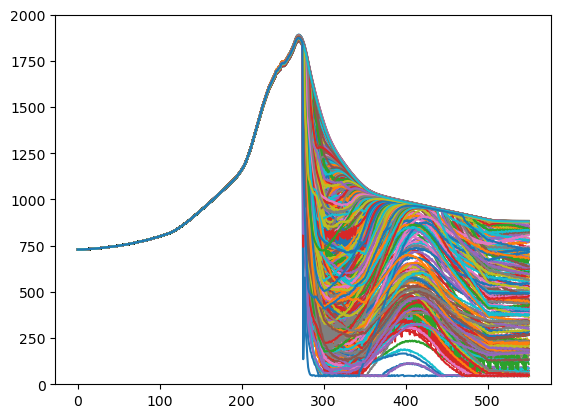

In [47]:
pl.plot(concentration_opt);
pl.ylim(0,2000);

In [48]:
species[55]

'Aerosol-cloud interactions'

In [49]:
emissions_opt = np.zeros((550, 3, n_ens))
emissions_opt[:274] = f_fut[2023].emissions[:, :, :, 3]
for year in range(2024, 2300):
    emissions_opt[year-1750] = f_fut[year].emissions[:, :, :, 3]
    
concentration_opt = np.zeros((551, 3, n_ens))
concentration_opt[:275] = f_fut[2023].concentration[:, :, :, 3]
for year in range(2024, 2300):
    concentration_opt[year-1749] = f_fut[year].concentration[1, :, :, 3]

forcing_ch4_opt = np.zeros((551, 3, n_ens))
forcing_ch4_opt[:275] = f_fut[2023].forcing[:, :, :, 3]
for year in range(2024, 2300):
    forcing_ch4_opt[year-1749] = f_fut[year].forcing[1, :, :, 3]

forcing_o3_opt = np.zeros((551, 3, n_ens))
forcing_o3_opt[:275] = f_fut[2023].forcing[:, :, :, 58]
for year in range(2024, 2300):
    forcing_o3_opt[year-1749] = f_fut[year].forcing[1, :, :, 58]    
    
forcing_sum_opt = np.zeros((551, 3, n_ens))
forcing_sum_opt[:275] = f_fut[2023].forcing_sum
for year in range(2024, 2300):
    forcing_sum_opt[year-1749] = f_fut[year].forcing_sum[1, :, :]
    
temperature_opt = np.zeros((551, 3, n_ens))
temperature_opt[:275] = f_fut[2023].temperature[:, :, :, 0]
for year in range(2024, 2300):
    temperature_opt[year-1749] = f_fut[year].temperature[1, :, :, 0] 
    
lifetime_opt = np.zeros((551, 3, n_ens))
lifetime_opt[:275] = f_fut[2023].alpha_lifetime[:, :, :, 3] * df_methane.loc["historical_best", "base"]
for year in range(2024, 2300):
    lifetime_opt[year-1749] = f_fut[year].alpha_lifetime[0, :, :, 3] * df_methane.loc["historical_best", "base"]

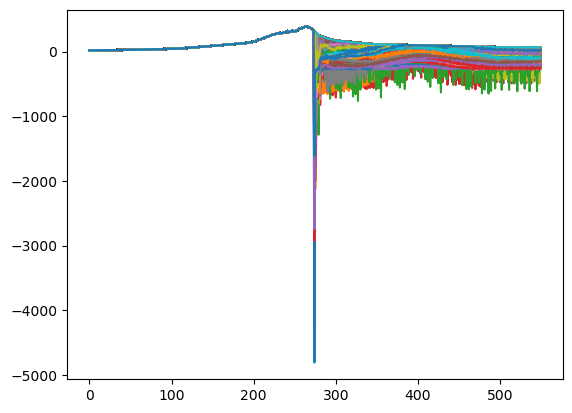

In [50]:
pl.plot(emissions_opt[:, 0, :]);

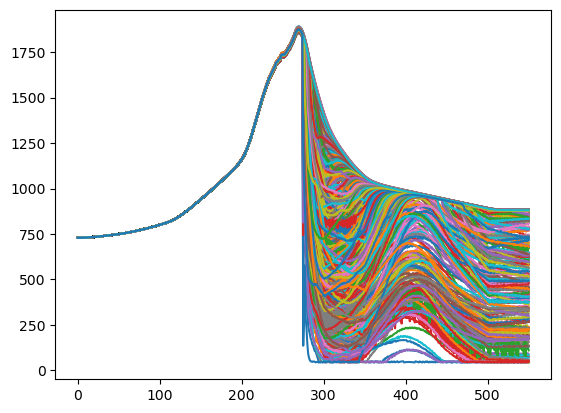

In [51]:
pl.plot(concentration_opt[:, 0, :]);

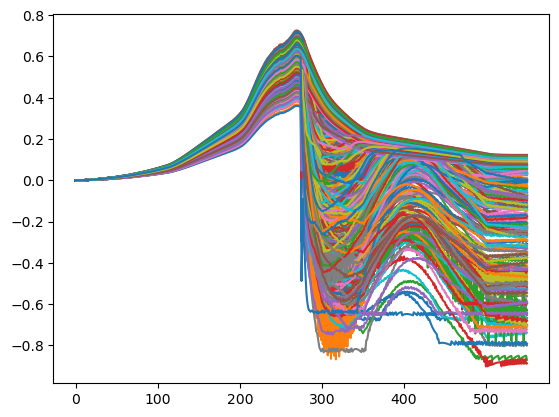

In [52]:
pl.plot(forcing_ch4_opt[:, 0, :]);

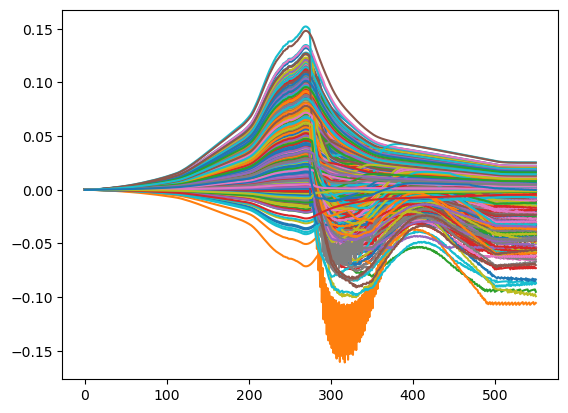

In [53]:
pl.plot(forcing_o3_opt[:, 0, :]);

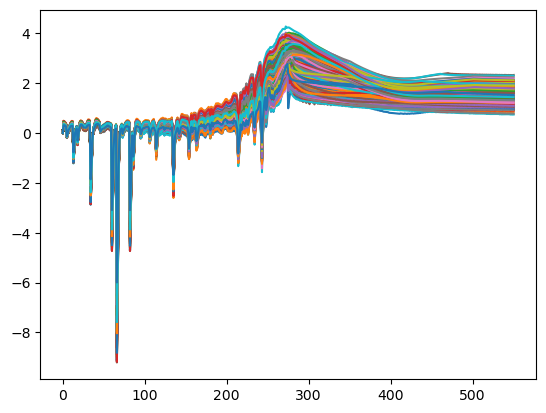

In [54]:
pl.plot(forcing_sum_opt[:, 0, :]);

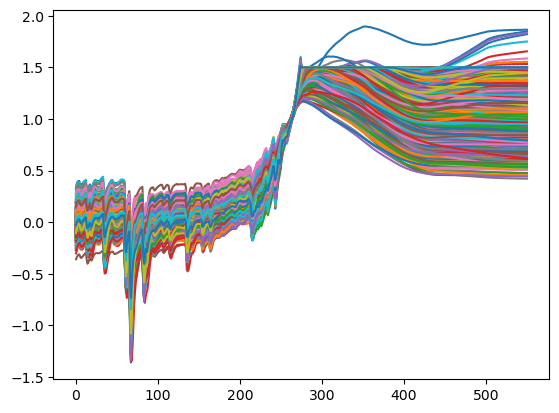

In [55]:
pl.plot(1.03 + temperature_opt[:, 0, :] - np.average(temperature_opt[253:274, 0, :], weights=temp_norm_20032022, axis=0));

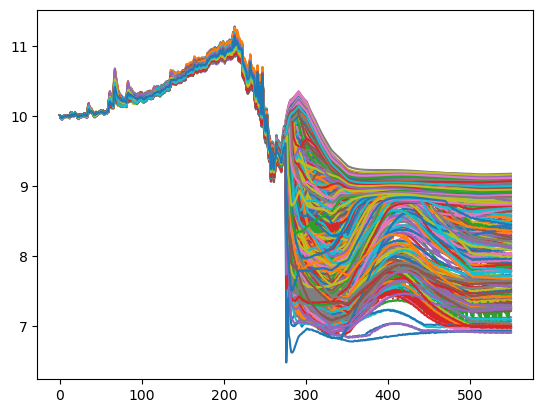

In [56]:
pl.plot(lifetime_opt[:, 0, :]);

In [57]:
ds_opt = xr.Dataset(
    data_vars = dict(
        emissions = (["timepoint", "scenario", "config"], emissions_opt),
        concentration = (["timebound", "scenario", "config"], concentration_opt),
        forcing_ch4 = (["timebound", "scenario", "config"], forcing_ch4_opt),
        forcing_o3 = (["timebound", "scenario", "config"], forcing_o3_opt),
        forcing_sum = (["timebound", "scenario", "config"], forcing_sum_opt),
        temperature = (["timebound", "scenario", "config"], temperature_opt),
        lifetime = (["timebound", "scenario", "config"], lifetime_opt),
    ),
    coords = dict(
        timepoint=np.arange(1750.5, 2300),
        timebound=np.arange(1750, 2301),
        scenario=scenarios,
        config=valid_all
    )
)

In [58]:
ds_opt

<xarray.Dataset>
Dimensions:        (timepoint: 550, scenario: 3, config: 841, timebound: 551)
Coordinates:
  * timepoint      (timepoint) float64 1.75e+03 1.752e+03 ... 2.298e+03 2.3e+03
  * timebound      (timebound) int64 1750 1751 1752 1753 ... 2297 2298 2299 2300
  * scenario       (scenario) <U34 'ssp119' ... 'COFFEE1.1 EN_NPi2020_400f_lo...
  * config         (config) int64 1439 2367 2658 ... 1595217 1595502 1597514
Data variables:
    emissions      (timepoint, scenario, config) float64 19.02 19.02 ... 59.7
    concentration  (timebound, scenario, config) float64 729.2 729.2 ... 901.8
    forcing_ch4    (timebound, scenario, config) float64 0.0 0.0 ... 0.1152
    forcing_o3     (timebound, scenario, config) float64 0.0 0.0 ... 0.004546
    forcing_sum    (timebound, scenario, config) float64 0.0 0.0 ... 1.462 1.501
    temperature    (timebound, scenario, config) float64 0.0 0.0 ... 1.513
    lifetime       (timebound, scenario, config) float64 10.01 10.01 ... 9.247

In [59]:
os.makedirs('../results', exist_ok=True)

In [60]:
f.to_netcdf('../results/noCH4R_cal-1.4.0.nc')

In [61]:
ds_opt.to_netcdf('../results/CH4R_cal-1.4.0.nc')

In [62]:
(f.alpha_lifetime[:, :, :, 3] * df_methane.loc["historical_best", "base"])

<xarray.DataArray (timebounds: 551, scenario: 3, config: 841)>
array([[[10.0069821 , 10.0069821 , 10.0069821 , ..., 10.0069821 ,
         10.0069821 , 10.0069821 ],
        [10.0069821 , 10.0069821 , 10.0069821 , ..., 10.0069821 ,
         10.0069821 , 10.0069821 ],
        [10.0069821 , 10.0069821 , 10.0069821 , ..., 10.0069821 ,
         10.0069821 , 10.0069821 ]],

       [[ 9.98167409,  9.98114485,  9.98475373, ...,  9.98054746,
          9.98225409,  9.98507547],
        [ 9.98167409,  9.98114485,  9.98475373, ...,  9.98054746,
          9.98225409,  9.98507547],
        [ 9.98167409,  9.98114485,  9.98475373, ...,  9.98054746,
          9.98225409,  9.98507547]],

       [[ 9.96412449,  9.96477767,  9.97339251, ...,  9.96003116,
          9.96753621,  9.97047672],
        [ 9.96412449,  9.96477767,  9.97339251, ...,  9.96003116,
          9.96753621,  9.97047672],
        [ 9.96412449,  9.96477767,  9.97339251, ...,  9.96003116,
          9.96753621,  9.97047672]],
...
       [[ 8.77123404,  8.77422083,  9.00252123, ...,  8.75850948,
          9.00281476,  8.71762897],
        [ 8.59180705,  8.54506131,  8.90899306, ...,  8.69805913,
          8.84817399,  8.62638169],
        [ 9.60780517,  9.58291197,  9.83774832, ...,  9.63752771,
          9.8494211 ,  9.54146435]],

       [[ 8.77135297,  8.77444191,  9.00278395, ...,  8.75855736,
          9.00310703,  8.71757328],
        [ 8.59209189,  8.54549213,  8.90944737, ...,  8.69831942,
          8.84859477,  8.62643718],
        [ 9.60813736,  9.58336954,  9.83815414, ...,  9.63775278,
          9.84991666,  9.54154186]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * timebounds  (timebounds) float64 1.75e+03 1.751e+03 ... 2.299e+03 2.3e+03
  * scenario    (scenario) <U34 'ssp119' ... 'COFFEE1.1 EN_NPi2020_400f_lowBE...
  * config      (config) int64 1439 2367 2658 2806 ... 1595217 1595502 1597514
    specie      <U43 'CH4'

In [63]:
# Save lifetime
(f.alpha_lifetime[:, :, :, 3] * df_methane.loc["historical_best", "base"]).to_netcdf('../results/noCH4R_lifetime_cal-1.4.0.nc')

In [64]:
# NEED TO GATHER INTO A DATASET

# pd.DataFrame(concentration_opt, index=f.timebounds, columns=valid_all).to_csv('../results/ssp119_CH4R_concentrations.csv')
# pd.DataFrame(emissions_opt, index=f.timepoints, columns=valid_all).to_csv('../results/ssp119_CH4R_emissions.csv')
# pd.DataFrame(forcing_opt, index=f.timebounds, columns=valid_all).to_csv('../results/ssp119_CH4R_forcing.csv')
# pd.DataFrame(temperature_opt, index=f.timebounds, columns=valid_all).to_csv('../results/ssp119_CH4R_temperature.csv')
# pd.DataFrame(forcing_sum_opt, index=f.timebounds, columns=valid_all).to_csv('../results/ssp119_CH4R_forcing_sum.csv')
# pd.DataFrame(lifetime_opt, index=f.timebounds, columns=valid_all).to_csv('../results/ssp119_CH4R_lifetime.csv')
pd.DataFrame(np.array([f.ebms.ecs, f.ebms.tcr]).T, index=valid_all, columns=['ECS', 'TCR']).to_csv('../results/ecs_tcr_cal-1.4.0.csv')